# Generating Neighborhood Data

## Asbestos
The asbestos dataset doesn't contain readable neighborhood information, and my previous method of trying to reverse zipcodes to neighborhoods didn't work. I'll instead be using geopandas to determine the neigborhoods of data in 
our datasets

I used this as a reference for the capabilities of this setup:
https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6

In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import shapely as shp
from shapely.geometry import Point, Polygon
import matplotlib as plt


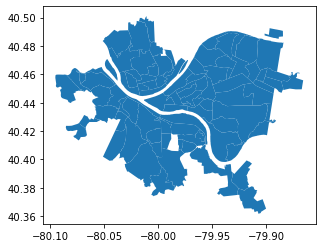

In [2]:
import shapely as shp
import matplotlib as plt
import geopandas as gpd

neighborhood_shapes = gpd.read_file("Neighborhoods_.geojson")
neighborhood_shapes.plot()

# Function which returns the neigborhood that a geographical location falls in
# This is used to combine the datasets
def getNeighborhood(latitude, longitude):
    point = shp.geometry.Point(longitude,latitude)
    # For each row in the shape data
    for _,x in neighborhood_shapes.iterrows():
        #Test if the point is within that neighborhood
        if(point.within(x["geometry"])):
            return x["hood"]
    
    return ""

In [ ]:
# import asbestos dataset
asbestos = pd.read_csv("Asbestos.csv")

#Filter to only pittsburgh
asbestos = asbestos[asbestos["city"]=="PITTSBURGH"]

# Create new array to store neighborhoods
neighborhoods = [] # new array

#Create array column of neighborhoods from the data
for _, row in asbestos.iterrows():
    neighborhoods.append(getNeighborhood(row["latitude"],row["longitude"]))

In [ ]:
# Add new column of neighborhoods to dataframe
asbestos["neighborhood"] = neighborhoods

# Filter for only the rows with valid neighborhoods
asbestos = asbestos[asbestos["neighborhood"]!=""]

# Create new file
asbestos.to_csv("data_with_neighborhoods/Asbestos_WithNeighborhood.csv")

## Restauraunt Inspections

Now that asbestos is done, the next step is normalizing the resturauntInspection dataset.
I'll have to use geocoding to get lat/long coordinates from a street adress for this dataset.

I used this website as a reference for this section:
https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [ ]:
#Import data
restaurants = pd.read_csv("restaurantInspections.csv")

# Filter for only Pittsburgh entries
restaurants = restaurants[restaurants["city"]=="Pittsburgh"]

# Construct adresses from data
restaurants_addresses = restaurants.apply(lambda row: "{} {}, {} {}".format(row["num"],row["street"],row["city"],row["state"]), axis=1)

# Add to original data, this will be used to get the lookup values
restaurants["address"] = restaurants_addresses

restaurants_addresses = restaurants_addresses.drop_duplicates()

print("Len:",len(restaurants_addresses.index))
print("Ratio:",len(restaurants_addresses.index)/len(restaurants.index))
print(restaurants_addresses)






In [ ]:

#Create new dictionary for neighborhoods
neighborhood_dict = {}

#Get locator
locator = Nominatim(user_agent="myGeocoder")

# set up progress bar
# This process takes a while because of rate limiting imposed by the api
progressBarSize = 50
progressBarIncrement = 1/progressBarSize
progress = 0

for x in range(progressBarSize):
    print("-", end = "")
print("")

index = 0

#For each address in the dataset, add the corresponding neighborhood to that row
print("This code block will take an extremely long time to run because of rate limits imposed by the geoencoding api."
          +"You do not need to run it again because the code saves the result as a csv you can import.")

response = input("\nWould you still like to run it? (Y/N) ")

if(response == "Y"):
    for row in restaurants_addresses:
        try:
            location = locator.geocode(row)
            neighborhoods.append(getNeighborhood(location.latitude,location.longitude))
            neighborhood_dict[row] = getNeighborhood(location.latitude,location.longitude)
        except:
            neighborhoods.append("")

        # Used to display the progress bar
        if(index/len(restaurants_addresses.index) > progress):
            print("=", end = "")
            progress+=progressBarIncrement
        index+=1

        print("")
        print("Done")

In [ ]:
# At this point, the neigborhoods_dict dictionary contains a lookup 
# for the neighborhoods of each adress in the data

#Create a new array for the neigborhoods
neighborhoods = []

for x in restaurants["address"]:
    # x should be in the dictionary, but just in case handle it
    if x in neighborhood_dict:
        neighborhoods.append(neighborhood_dict[x])
    else:
        neighborhoods.append("")

# Add new column of neighborhoods to dataframe
restaurants["neighborhood"] = neighborhoods

# Filter for only the rows with valid neighborhoods
restaurants_valid = restaurants[restaurants["neighborhood"]!=""]

# Create new file
restaurants_valid.to_csv("data_with_neighborhoods/restaurantInspections_WithNeighborhood.csv")

## Air Quality

The last dataset to deal with is air quality, which is a bit of a doozy because of how the data is collected. 
The data in this set is collected from a bunch of air monitoring sites located in various places in Alegheny county. There aren't one of these in every neighborhood though, so just taking the data from all the sites isn't an option. 

In [43]:
airQuality_Locations = pd.read_csv("airQuality_Locations.csv")
airQuality = pd.read_csv("airQuality.csv")

airQuality_UniqueLocations = airQuality.drop_duplicates("site")


C:\Users\Owner\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [50]:

# Each column stores multiple different statistics about the property measured
# Select only the average measure of so2
airQuality_Average = airQuality[airQuality["stat"]=="Avg"][["site","datetime","so2"]]
airQuality_Average = airQuality_Average


#Display both the sites and number of times they were referenced
print(airQuality_Average.groupby("site"))
print(airQuality_Average[airQuality_Average["so2"]!=0])

                     site             datetime  so2
49             Flag Plaza  2016-01-15T00:00:00  NaN
56             Flag Plaza  2016-01-16T00:00:00  NaN
62             Flag Plaza  2016-01-17T00:00:00  NaN
68             Flag Plaza  2016-01-18T00:00:00  NaN
74             Flag Plaza  2016-01-19T00:00:00  NaN
...                   ...                  ...  ...
158238  Harrison Township  2021-04-02T00:00:00  NaN
158247      Lawrenceville  2021-04-02T00:00:00  NaN
158262          Liberty 2  2021-04-02T00:00:00  NaN
158277       Parkway East  2021-04-02T00:00:00  NaN
158280         Pittsburgh  2021-04-02T00:00:00  NaN

[20950 rows x 3 columns]


---
Notice that for some reason, there are entries with a 2 appended to them, or the one case of (Near Road) being used as a site name. I have no idea why this is, but I have to normalize them. I can't find information as to what those modifiers mean, but I'm going to assume they reference the same sensor location as their base name. 

---

In [19]:
import math

# Function to get the closest site to a location
def getClosestAirQualitySite(latitude, longitude):
    minDist = -1
    minSite = {}
    for _,site in airQuality_Locations.iterrows():
        # Calculate geographical distance
        lat = site["latitude"]-latitude
        lon = site["longitude"]-longitude
        dist = math.sqrt(lat*lat+lon*lon)
        
        # Update closest site if closest
        if minDist == -1 or dist < minDist:
            minDist = dist
            minSite = site
            
    return minSite



In [8]:
# New array for neighborhoods
neighborhoods = []

# Create array of neighborhoods based on location of data collecting sites
for _, row in airQuality_Locations.iterrows():
    neighborhoods.append(getNeighborhood(row["latitude"],row["longitude"]))

# add the neighborhoods to the data
airQuality_Locations["neighborhood"] = neighborhoods

print(airQuality_Locations[["site","neighborhood"]])

              site         neighborhood
0    Lawrenceville  Lower Lawrenceville
1          Liberty                     
2          Lincoln                     
3        Glassport                     
4   North Braddock                     
5         Harrison                     
6    South Fayette                     
7         Clairton                     
8           Avalon                     
9       Flag Plaza     Crawford-Roberts
10      Manchester           Manchester
11      North Park                     
12    Parkway East                     
13    West Mifflin                     


In [29]:

#Create array for neighborhoods in the data
neighborhoods = []
#Create corresponding closest site result
closest_sites = []

for _,hood_shape in neighborhood_shapes.iterrows():
        #Test if the point is within that neighborhood
        center = hood_shape.geometry.centroid
        closestSite = getClosestAirQualitySite(center.y,center.x)
        closest_sites.append(closestSite["site"])
        neighborhoods.append(hood_shape["hood"])
        
airQuality_NeighborhoodSites = pd.DataFrame({"neighborhood":neighborhoods,"closest_site":closest_sites})
print(airQuality_NeighborhoodSites.head(10))
#print(airQuality_NeighborhoodSites[airQuality_NeighborhoodSites["neighborhood"]=="Manchester"])

            neighborhood closest_site
0                Chateau   Manchester
1            Summer Hill   Manchester
2      Northview Heights   Manchester
3  Spring Hill-City View   Flag Plaza
4            Perry South   Manchester
5               Fineview   Manchester
6      Central Northside   Manchester
7          Spring Garden   Flag Plaza
8              Troy Hill   Flag Plaza
9         East Allegheny   Flag Plaza


In [ ]:
airQuality

C:\Users\Owner\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Figure size 3636x1332 with 0 Axes>

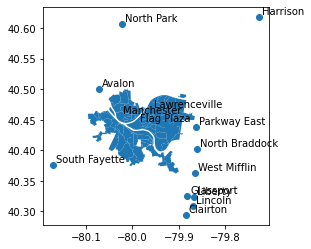

In [39]:
from matplotlib.patches import Polygon as PatchesPolygon

geometry=[Point(xy) for xy in zip(airQuality_Locations["longitude"], airQuality_Locations["latitude"])]

crs={'init':'epsg:4326'}
geo = gpd.GeoDataFrame(airQuality_Locations,crs=crs,geometry=geometry)

fig = plt.pyplot.gcf()
fig.set_size_inches(50.5, 18.5,forward = True)

possibleColors = ["#FF0000","#FFFF00","#FF00FF","#00FF00","#00FFFF","#0000FF",]
colors = []

index = 0
for _,row in neighborhood_shapes.iterrows():
    colors.append(possibleColors[index%len(possibleColors)])
    index+=1

plot =  geo.append(neighborhood_shapes).plot()

patches = []

for point, label in zip(geometry, airQuality_Locations["site"]):
    plot.annotate(label, xy=(point.x, point.y), xytext=(3, 3), textcoords="offset points")
    
